# EDA – Dataset de Teatro Musical en España

Este cuaderno recoge el análisis exploratorio de un dataset de producciones de teatro musical en España. El objetivo es entender la actividad del sector (obras, productoras, giras, periodos de exhibición y localizaciones principales) y dejar el conjunto de datos listo para fases posteriores de visualización y modelado.


## Sobre la construcción del dataset

El dataset no procede de una base oficial, sino que ha sido construido de forma manual a partir de páginas oficiales de los musicales, notas de prensa, hemerotecas y plataformas de venta de entradas. 

El criterio profesional y el conocimiento del sector han sido claves para contrastar fechas, productoras y espacios, resolviendo inconsistencias entre distintas fuentes cuando ha sido necesario.

No pretende ser un registro definitivo de todas las producciones, pero sí una base suficientemente sólida y coherente para analizar patrones de programación, actividad por productora y evolución temporal del teatro musical en España.


## 1. Carga y revisión inicial del dataset

En esta sección se cargan los datos desde el fichero CSV original y se revisa su estructura básica: número de filas y columnas, tipos de datos, valores nulos y cardinalidad de las variables.


In [158]:
import pandas as pd          # Manejo y análisis de datos en tablas (DataFrames)
from IPython.display import display  # Muestra objetos de forma clara en notebooks
import matplotlib.pyplot as plt      # Crear gráficos y visualizaciones
import seaborn as sns        # Gráficos estadísticos atractivos (basado en matplotlib)
from matplotlib.lines import Line2D  # Crear o personalizar líneas en gráficos

In [159]:
df = pd.read_csv("musicales_limpio_final.csv")

In [160]:
df.shape
df.info()
df.isna().sum()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   obra              61 non-null     object 
 1   productora        61 non-null     object 
 2   anio_inicio       61 non-null     int64  
 3   anio_fin          48 non-null     float64
 4   teatro            58 non-null     object 
 5   ciudad_principal  60 non-null     object 
 6   gira              61 non-null     object 
 7   fuente_url        46 non-null     object 
 8   activa            61 non-null     bool   
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 4.0+ KB


obra                53
productora          11
anio_inicio         23
anio_fin            19
teatro              29
ciudad_principal     5
gira                 2
fuente_url          43
activa               2
dtype: int64

Ajustamos la columna `anio_fin` al tipo entero que permite nulos (`Int64`), ya que algunas producciones siguen en activo y no tienen año de fin cerrado.

In [161]:
df['anio_fin'] = df ['anio_fin'].astype('Int64')

In [162]:
df['obra'] = df['obra'].str.replace(r"\s*\(.*?\)", "", regex=True).str.strip()


In [163]:
print(df.columns)

Index(['obra', 'productora', 'anio_inicio', 'anio_fin', 'teatro',
       'ciudad_principal', 'gira', 'fuente_url', 'activa'],
      dtype='object')


In [164]:
def eda_inicial(df):
    df = df.copy()

    # ==========================
    # 1. VISTA GENERAL
    # ==========================
    print(f"Dimensiones del dataset: {df.shape[0]} filas x {df.shape[1]} columnas\n")

    print("Primeras 5 filas:")
    display(df.head())

    print("\nTipos de datos:")
    display(df.dtypes.to_frame("tipo"))

    # Separación de tipos
    num_cols = df.select_dtypes(include="number").columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    print(f"\nColumnas numéricas:   {len(num_cols)}")
    print(f"Columnas categóricas: {len(cat_cols)}")

    # ==========================
    # 2. ESTADÍSTICAS DESCRIPTIVAS
    # ==========================
    if num_cols:
        print("\nEstadísticas descriptivas (numéricas):")
        display(df[num_cols].describe().T)

    if cat_cols:
        print("\nEstadísticas descriptivas (categóricas):")
        display(df[cat_cols].describe().T)

    # ==========================
    # 3. NULOS
    # ==========================
    print("\nValores nulos por columna:")
    nulos_df = pd.DataFrame({
        "nulos": df.isnull().sum(),
        "% nulos": (df.isnull().mean() * 100).round(2)
    }).sort_values("% nulos", ascending=False)

    if nulos_df["nulos"].sum() == 0:
        print("No se encontraron valores nulos.")
    else:
        display(nulos_df[nulos_df["nulos"] > 0])

    # ==========================
    # 4. DUPLICADOS (TODAS LAS COLUMNAS)
    # ==========================
    print("\n--- DUPLICADOS GENERALES ---")
    dup_count = df.duplicated().sum()
    if dup_count == 0:
        print("No hay filas completamente duplicadas.")
    else:
        print(f"Hay {dup_count} filas completamente duplicadas.")
        duplicadas = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist())
        display(duplicadas)

    # ==========================
    # 5. DUPLICADOS POR CLAVES LÓGICAS
    #    (AJUSTA LOS NOMBRES SI HACE FALTA)
    # ==========================
    claves = ["obra", "productora", "anio_inicio"]  # cambia anio_inicio si tu columna se llama distinto

    print(f"\n--- DUPLICADOS POR CLAVES {claves} ---")
    if not set(claves).issubset(df.columns):
        print("No se pueden revisar duplicados por claves: falta alguna de esas columnas.")
    else:
        dup_claves = df[df.duplicated(subset=claves, keep=False)].sort_values(by=claves)
        if dup_claves.empty:
            print("No hay duplicados por esa combinación de claves.")
        else:
            print("Filas potencialmente duplicadas por obra–productora–año:")
            display(dup_claves)

    # ==========================
    # 6. RESUMEN FINAL
    # ==========================
    resumen = pd.DataFrame({
        "columna": df.columns,
        "tipo": df.dtypes.astype(str).values,
        "valores_únicos": df.nunique().values,
        "% nulos": (df.isnull().mean() * 100).round(2).values
    })

    print("\nResumen general de columnas:")
    display(resumen)

    return resumen


In [165]:
resumen = eda_inicial (df)

Dimensiones del dataset: 61 filas x 9 columnas

Primeras 5 filas:


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
0,"101 Dálmatas, el musical",Teatropolis (Gran Teatro CaixaBank Príncipe Pío),2023,<NA>,Gran Teatro CaixaBank Príncipe Pío,Madrid,No,https://www.granteatroprincipepio.com/,True
1,Aladdín,Stage Entertainment,2023,2025,Teatro Coliseum,Madrid,No,https://www.stage.es/musicales/aladdin/,False
2,Anastasia,Stage Entertainment,2018,2020,Teatro Coliseum,Madrid,No,https://www.stage.es/musicales/anastasia/,False
3,Avenue Q,Teatropolis (Gran Teatro CaixaBank Príncipe Pío),2024,<NA>,Gran Teatro CaixaBank Príncipe Pío,Madrid,No,https://www.granteatroprincipepio.com/,True
4,Billy Elliot,SOM Produce,2017,2020,Nuevo Teatro Alcalá,Madrid,Sí,https://somproduce.com/musicales/billy-elliot/,False



Tipos de datos:


,tipo
obra,object
productora,object
anio_inicio,int64
anio_fin,Int64
teatro,object
ciudad_principal,object
gira,object
fuente_url,object
activa,bool



Columnas numéricas:   2
Columnas categóricas: 6

Estadísticas descriptivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
anio_inicio,61.0,2016.229508,7.785442,1999.0,2009.0,2018.0,2023.0,2025.0
anio_fin,48.0,2016.770833,7.82587,2002.0,2009.0,2020.0,2024.0,2025.0



Estadísticas descriptivas (categóricas):


,count,unique,top,freq
obra,61,53,Cabaret,2
productora,61,11,Stage Entertainment,21
teatro,58,29,Teatro Coliseum,10
ciudad_principal,60,5,Madrid,51
gira,61,2,Sí,38
fuente_url,46,43,https://www.granteatroprincipepio.com/,3



Valores nulos por columna:


,nulos,% nulos
fuente_url,15,24.59
anio_fin,13,21.31
teatro,3,4.92
ciudad_principal,1,1.64



--- DUPLICADOS GENERALES ---
Hay 1 filas completamente duplicadas.


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,NaN,False
60,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,NaN,False



--- DUPLICADOS POR CLAVES ['obra', 'productora', 'anio_inicio'] ---
Filas potencialmente duplicadas por obra–productora–año:


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,NaN,False
60,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,NaN,False



Resumen general de columnas:


,columna,tipo,valores_únicos,% nulos
0,obra,object,53,0.00
1,productora,object,11,0.00
2,anio_inicio,int64,23,0.00
3,anio_fin,Int64,19,21.31
4,teatro,object,29,4.92
5,ciudad_principal,object,5,1.64
6,gira,object,2,0.00
7,fuente_url,object,43,24.59
8,activa,bool,2,0.00


## 2. Tratamiento de duplicados y consolidación

A partir de la revisión inicial se detectan posibles duplicados. Aquí se eliminan filas repetidas y se definen claves lógicas (obra–productora–año de inicio) para identificar registros redundantes y consolidar la información de cada producción.


In [166]:
# PASO 1: eliminar filas completamente duplicadas
df = df.drop_duplicates()


In [167]:
# PASO 2: eliminar duplicados por claves lógicas (obra-productora-anio_inicio)

df = df.sort_values(by=["obra", "productora", "anio_inicio"])
df = df.drop_duplicates(subset=["obra", "productora", "anio_inicio"], keep="first")


In [168]:
# PASO 3: consolidación de columnas dentro de cada producción

def consolidar_grupo(grupo):
    # función auxiliar para devolver valor más frecuente ignorando vacíos y guiones
    def modo_util(col):
        col = col.dropna()
        col = col[col.astype(str).str.strip().isin(["", "-", "None"]) == False]
        if len(col) == 0:
            return None
        return col.mode().iloc[0]

    return pd.Series({
        "obra": grupo["obra"].iloc[0],
        "productora": grupo["productora"].iloc[0],
        "anio_inicio": grupo["anio_inicio"].iloc[0],
        "anio_fin": grupo["anio_fin"].min(),  # nos quedamos con el más antiguo si es igual
        "teatro": modo_util(grupo["teatro"]),
        "ciudad_principal": modo_util(grupo["ciudad_principal"]),
        "gira": "Sí" if "Sí" in grupo["gira"].values else "No",
        "fuente_url": modo_util(grupo["fuente_url"]),
        "activa": grupo["activa"].max() if "activa" in grupo.columns else None
    })

# agrupamos por producción real
df = df.groupby(["obra", "productora", "anio_inicio"]).apply(consolidar_grupo).reset_index(drop=True)


C:\Users\elaru\AppData\Local\Temp\ipykernel_32236\4186353718.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["obra", "productora", "anio_inicio"]).apply(consolidar_grupo).reset_index(drop=True)


In [169]:
df.duplicated(subset=["obra", "productora", "anio_inicio"]).sum()


np.int64(0)

In [170]:
df["fuente_url"].unique()


array(['https://www.granteatroprincipepio.com/',
       'https://www.stage.es/musicales/aladdin/',
       'https://www.stage.es/musicales/anastasia/',
       'https://somproduce.com/musicales/billy-elliot/',
       'fuente: observación personal',
       'https://es.wikipedia.org/wiki/Cabaret_(musical)#Producciones_en_España',
       None,
       'https://www.teatroalamedia.com/charlie-y-la-fabrica-de-chocolate/',
       'https://somproduce.com/musicales/chicago/',
       'https://es.wikipedia.org/wiki/Chicago_(musical)#Producciones_en_España',
       'https://www.entradas.com/artist/dirty-dancing/',
       'https://www.nostromolive.com/espectaculos/el-dia-de-la-marmota/',
       'https://umusic-hotels.com/madrid/eventos/el-fantasma-de-la-opera/',
       'https://es.wikipedia.org/wiki/El_Guardaespaldas_(musical)#Producciones',
       'https://www.beonworldwide.com/proyectos/el-medico-el-musical/',
       'https://www.stage.es/musicales/el-rey-leon/',
       'https://www.beonworldwide.co

In [171]:
df[df["teatro"].astype(str).str.strip().isin(["", "-", "None"])]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
15,El Fantasma de la Ópera,Stage Entertainment,2002,2004,None,Madrid,No,None,False
30,Kinky Boots,Theatre Properties,2024,2025,None,Gira,Sí,None,False
32,La Bella y la Bestia,Stage Entertainment,1999,2002,None,Madrid,No,None,False


In [172]:
df[df["obra"] == "Fiebre del sábado noche"]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
22,Fiebre del sábado noche,Stage Entertainment,2009,2009,Teatro Coliseum,Madrid,Sí,None,False


## 3. Correcciones manuales de casos concretos

En esta sección se corrigen casos particulares en los que la información de años, teatros o ciudades es conocida pero aparecía incompleta o inconsistente en el dataset original. Estas correcciones se apoyan en la revisión de fuentes externas.


In [173]:
df.loc[df["obra"] == "Fiebre del sábado noche", "anio_fin"] = 2009
df.loc[df["obra"] == "Fiebre del sábado noche", "activa"] = False
df.loc[df["obra"] == "Fiebre del sábado noche", "gira"] = "Sí"


In [174]:
df.loc[df["obra"] == "Fiebre del sábado noche", "teatro"] = "Teatro Coliseum"


In [175]:
df["productora"].unique()


array(['Teatropolis (Gran Teatro CaixaBank Príncipe Pío)',
       'Stage Entertainment', 'SOM Produce', "Let's Go Company",
       'Nostromo Live', 'Beon Entertainment', 'Drive Entertainment',
       'Theatre Properties', 'Dagoll Dagom', 'Suma Latina / Los Javis',
       'Smedia / Drive Entertainment'], dtype=object)

In [176]:
df["productora"] = df["productora"].replace({
    "Teatre Properties": "Theatre Properties"
})


In [177]:
df[df["productora"] == "Stage Entertainment"].sort_values("anio_inicio")


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
32,La Bella y la Bestia,Stage Entertainment,1999,2002,None,Madrid,No,None,False
48,My Fair Lady,Stage Entertainment,2001,2002,Teatro Coliseum,Madrid,No,None,False
15,El Fantasma de la Ópera,Stage Entertainment,2002,2004,None,Madrid,No,None,False
7,Cats,Stage Entertainment,2003,2005,Teatro Lope de Vega,Madrid,No,None,False
58,Víctor o Victoria,Stage Entertainment,2005,2006,Teatro Coliseum,Madrid,No,None,False
6,Cabaret,Stage Entertainment,2006,2007,Teatro Nuevo Alcalá,Madrid,Sí,https://es.wikipedia.org/wiki/Cabaret_(musical...,False
42,Los Productores,Stage Entertainment,2006,2006,Teatro Coliseum,Madrid,No,None,False
28,Jesucristo Superstar,Stage Entertainment,2007,2008,Teatro Lope de Vega,Madrid,Sí,https://es.wikipedia.org/wiki/Jesucristo_Super...,False
44,Mamma Mia!,Stage Entertainment,2007,2009,Teatro Lope de Vega,Madrid,Sí,https://es.wikipedia.org/wiki/Mamma_Mia!_(musi...,False
53,Sonrisas y Lágrimas,Stage Entertainment,2007,2008,Teatro Coliseum,Madrid,Sí,https://es.wikipedia.org/wiki/Sonrisas_y_l%C3%...,False


In [178]:
df.loc[
    (df["obra"] == "Los Productores") &
    (df["productora"] == "Stage Entertainment"),
    ["anio_fin", "activa", "teatro"]
] = [2006, False, "Teatro Coliseum"]


In [179]:
df[(df["obra"] == "Los Productores") & (df["productora"] == "Stage Entertainment")]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
42,Los Productores,Stage Entertainment,2006,2006,Teatro Coliseum,Madrid,No,None,False


In [180]:
df_som = df[df["productora"] == "SOM Produce"].sort_values("obra")
df_som


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
4,Billy Elliot,SOM Produce,2017,2020,Nuevo Teatro Alcalá,Madrid,Sí,https://somproduce.com/musicales/billy-elliot/,False
10,Chicago,SOM Produce,2023,2025,Teatro Apolo,Madrid,Sí,https://somproduce.com/musicales/chicago/,False
21,"Fama, el Musical",SOM Produce,2004,2006,Teatro Rialto,Madrid,Sí,https://es.wikipedia.org/wiki/Fama_(musical),False
24,Grease,SOM Produce,2021,2023,Nuevo Teatro Alcalá,Madrid,Sí,https://somproduce.com/musicales/grease/,False
38,Los Miserables,SOM Produce,2025,<NA>,Teatro Apolo (prev.),Madrid,No,https://somproduce.com/musicales/los-miserables/,True
43,Mamma Mia!,SOM Produce,2022,<NA>,Teatro Rialto,Madrid,Sí,https://somproduce.com/musicales/mamma-mia/,True
47,Matilda,SOM Produce,2022,2024,Nuevo Teatro Alcalá,Madrid,No,https://somproduce.com/musicales/matilda/,False
49,"Priscilla, reina del desierto",SOM Produce,2014,2015,Nuevo Teatro Alcalá,Madrid,Sí,https://somproduce.com/musicales/priscilla/,False
54,The Book of Mormon,SOM Produce,2023,<NA>,Teatro Calderón / Rialto,Madrid,No,https://somproduce.com/musicales/the-book-of-m...,True


In [181]:
df.loc[
    (df["obra"] == "Chicago") &
    (df["productora"] == "SOM Produce") &
    (df["anio_fin"] == 2024),
    "anio_fin"
] = 2025


In [182]:
df[(df["obra"] == "Chicago") & (df["productora"] == "SOM Produce")]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
10,Chicago,SOM Produce,2023,2025,Teatro Apolo,Madrid,Sí,https://somproduce.com/musicales/chicago/,False


In [183]:
df["productora"].unique()


array(['Teatropolis (Gran Teatro CaixaBank Príncipe Pío)',
       'Stage Entertainment', 'SOM Produce', "Let's Go Company",
       'Nostromo Live', 'Beon Entertainment', 'Drive Entertainment',
       'Theatre Properties', 'Dagoll Dagom', 'Suma Latina / Los Javis',
       'Smedia / Drive Entertainment'], dtype=object)

In [184]:
df_letsgo = df[df["productora"] == "Let's Go Company"].sort_values("obra")
df_letsgo


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
5,Cabaret,Let's Go Company,2025,<NA>,Albéniz,Madrid,No,fuente: observación personal,True
9,Charlie y la fábrica de chocolate,Let's Go Company,2021,2022,Espacio Ibercaja Delicias,Madrid,Sí,https://www.teatroalamedia.com/charlie-y-la-fa...,False
12,Dirty Dancing,Let's Go Company,2018,2023,Teatro Nuevo Alcalá,Madrid,Sí,https://www.entradas.com/artist/dirty-dancing/,False
14,El Fantasma de la Ópera,Let's Go Company,2023,<NA>,UMusic Hotel Teatro Albéniz,Madrid,Sí,https://umusic-hotels.com/madrid/eventos/el-fa...,True
17,El Jovencito Frankenstein,Let's Go Company,2018,2019,Teatro Gran Vía,Madrid,No,None,False
23,"Ghost, el musical",Let's Go Company,2019,2024,Teatro EDP Gran Vía,Madrid,Sí,https://www.lacoctelera.com/ghost-el-musical/,False
26,Houdini,Let's Go Company,2025,<NA>,Teatro Calderón,Madrid,No,None,True
29,Kinky Boots,Let's Go Company,2021,2022,Espacio Delicias / Teatro Calderón,Madrid,No,None,False
33,La Familia Addams,Let's Go Company,2017,2018,Teatro Calderón,Madrid,Sí,https://www.entradas.com/artist/la-familia-add...,False
51,School of Rock,Let's Go Company,2024,2024,Espacio Delicias,Madrid,No,None,False


In [185]:
df.loc[
    (df["obra"] == "Dirty Dancing") &
    (df["productora"] == "Let's Go Company"),
    ["anio_inicio", "anio_fin", "teatro"]
] = [2018, 2023, "Teatro Nuevo Alcalá"]


In [186]:
df[(df["obra"] == "Dirty Dancing") & (df["productora"] == "Let's Go Company")]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
12,Dirty Dancing,Let's Go Company,2018,2023,Teatro Nuevo Alcalá,Madrid,Sí,https://www.entradas.com/artist/dirty-dancing/,False


In [187]:
df.loc[
    (df["obra"] == "Ghost") &
    (df["productora"] == "Let's Go Company"),
    ["anio_inicio", "anio_fin", "teatro"]
] = [2019, 2024, "Teatro EDP Gran Vía"]


In [188]:
df.loc[
    df["obra"].str.contains("Ghost", case=False, na=False) &
    (df["productora"] == "Let's Go Company"),
    ["anio_inicio", "anio_fin", "teatro"]
] = [2019, 2024, "Teatro EDP Gran Vía"]


In [189]:
df[
    df["obra"].str.contains("Ghost", case=False, na=False) &
    (df["productora"] == "Let's Go Company")
]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
23,"Ghost, el musical",Let's Go Company,2019,2024,Teatro EDP Gran Vía,Madrid,Sí,https://www.lacoctelera.com/ghost-el-musical/,False


In [190]:
df[(df["obra"] == "Kinky Boots") & (df["productora"] == "Let's Go Company")]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
29,Kinky Boots,Let's Go Company,2021,2022,Espacio Delicias / Teatro Calderón,Madrid,No,None,False


In [191]:
mask_mal = (
    (df["obra"] == "Kinky Boots") &
    (df["productora"] == "Let's Go Company") &
    (df["anio_inicio"] == 2024) &
    (df["anio_fin"] == 2025)
)

df = df[~mask_mal]


In [192]:
df[(df["obra"] == "Kinky Boots") & (df["productora"] == "Let's Go Company")]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
29,Kinky Boots,Let's Go Company,2021,2022,Espacio Delicias / Teatro Calderón,Madrid,No,None,False


In [193]:
df_nostromo = df[df["productora"] == "Nostromo Live"].sort_values("obra")
df_nostromo


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
13,El Día de la Marmota,Nostromo Live,2024,2025,Teatro Coliseum (BCN),Barcelona,No,https://www.nostromolive.com/espectaculos/el-d...,False
35,La Jaula de las Locas,Nostromo Live,2018,2020,Teatro Tívoli,Barcelona,Sí,https://www.nostromolive.com/espectaculos/la-j...,False
41,Los Productores,Nostromo Live,2023,2024,Teatro Tívoli,Barcelona,Sí,https://www.nostromolive.com/espectaculos/los-...,False


In [194]:
df_beon = df[df["productora"] == "Beon Entertainment"].sort_values("obra")
df_beon


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
18,El Médico,Beon Entertainment,2018,2023,Teatro Nuevo Apolo,Madrid,Sí,https://www.beonworldwide.com/proyectos/el-med...,False
20,El Tiempo entre Costuras,Beon Entertainment,2021,2024,Teatro Principal de Zaragoza,Madrid,Sí,https://www.beonworldwide.com/proyectos/el-tie...,False
34,La Historia Interminable,Beon Entertainment,2022,2024,Teatro Calderón,Madrid,Sí,https://www.beonworldwide.com/proyectos/la-his...,False
40,Los Pilares de la Tierra,Beon Entertainment,2024,<NA>,Teatro EDP Gran Vía,Madrid,Sí,https://www.beonworldwide.com/proyectos/los-pi...,True


In [195]:
df.loc[
    (df["obra"] == "El Médico") &
    (df["productora"] == "Beon Entertainment"),
    "anio_fin"
] = 2023


In [196]:
df[(df["obra"] == "El Médico") & (df["productora"] == "Beon Entertainment")]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
18,El Médico,Beon Entertainment,2018,2023,Teatro Nuevo Apolo,Madrid,Sí,https://www.beonworldwide.com/proyectos/el-med...,False


In [197]:
df_drive = df[df["productora"] == "Drive Entertainment"].sort_values("obra")
df_drive


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
27,Hoy no me puedo levantar,Drive Entertainment,2005,2017,Teatro Rialto / Coliseum,Madrid,Sí,https://es.wikipedia.org/wiki/Hoy_no_me_puedo_...,False


In [198]:
df_tp = df[df["productora"] == "Theatre Properties"].sort_values("obra")
df_tp


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
30,Kinky Boots,Theatre Properties,2024,2025,None,Gira,Sí,None,False
50,"Romeo y Julieta, el musical",Theatre Properties,2021,2024,La Latina,Madrid / Gira,Sí,https://www.carteleramusicales.es/madrid-provi...,False
55,"The Full Monty, el musical",Theatre Properties,2022,2023,Teatro Rialto,Madrid,Sí,https://www.elcorteingles.es/entradas/teatro/e...,False


In [199]:
df.loc[
    (df["obra"] == "Romeo y Julieta, el musical") &
    (df["productora"] == "Theatre Properties"),
    ["anio_inicio", "anio_fin", "teatro", "activa"]
] = [2021, 2024, "La Latina", False]


In [200]:
df[
    (df["obra"] == "Romeo y Julieta, el musical") &
    (df["productora"] == "Theatre Properties")
]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
50,"Romeo y Julieta, el musical",Theatre Properties,2021,2024,La Latina,Madrid / Gira,Sí,https://www.carteleramusicales.es/madrid-provi...,False


In [201]:
df_dagoll = df[df["productora"] == "Dagoll Dagom"].sort_values("obra")
df_dagoll


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
31,La Alegría que Pasa,Dagoll Dagom,2022,2023,Teatre Poliorama,Barcelona,Sí,https://www.dagolldagom.com/espectacle/la-aleg...,False
45,Mar i Cel,Dagoll Dagom,2004,2006,Teatre Victòria / Gira,Barcelona / Madrid,Sí,https://es.wikipedia.org/wiki/Mar_i_Cel,False
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False


In [202]:
nueva_fila = {
    "obra": "Mari i Cel",
    "productora": "Dagoll Dagom",
    "anio_inicio": 2024,
    "anio_fin": 2025,
    "teatro": "Teatre Victòria",
    "ciudad_principal": "Barcelona",
    "gira": "Sí",
    "fuente_url": None,
    "activa": False
}

df = pd.concat([df, pd.DataFrame([nueva_fila])], ignore_index=True)


In [203]:
df_dagoll = df[df["productora"] == "Dagoll Dagom"].sort_values("obra")
df_dagoll


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
31,La Alegría que Pasa,Dagoll Dagom,2022,2023,Teatre Poliorama,Barcelona,Sí,https://www.dagolldagom.com/espectacle/la-aleg...,False
45,Mar i Cel,Dagoll Dagom,2004,2006,Teatre Victòria / Gira,Barcelona / Madrid,Sí,https://es.wikipedia.org/wiki/Mar_i_Cel,False
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False
60,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False


In [204]:
df_sl = df[df["productora"] == "Suma Latina / Los Javis"].sort_values("obra")
df_sl


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
36,La Llamada,Suma Latina / Los Javis,2013,<NA>,Teatro Lara,Madrid,Sí,https://es.wikipedia.org/wiki/La_llamada_(musi...,True


In [205]:
df.loc[
    (df["obra"] == "La Llamada") &
    (df["productora"] == "Suma Latina / Los Javis"),
    ["anio_fin", "teatro", "activa"]
] = [None, "Teatro Lara", True]


In [206]:
df[
    (df["obra"] == "La Llamada") &
    (df["productora"] == "Suma Latina / Los Javis")
]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
36,La Llamada,Suma Latina / Los Javis,2013,None,Teatro Lara,Madrid,Sí,https://es.wikipedia.org/wiki/La_llamada_(musi...,True


In [207]:
df_smedia = df[df["productora"] == "Smedia / Drive Entertainment"].sort_values("obra")
df_smedia


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
37,Los 40 El Musical,Smedia / Drive Entertainment,2009,2012,Teatro Rialto,Madrid,Sí,https://es.wikipedia.org/wiki/Los_40_El_Musical,False


In [208]:
df.shape


(61, 9)

In [209]:
df.head(20)


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
0,"101 Dálmatas, el musical",Teatropolis (Gran Teatro CaixaBank Príncipe Pío),2023,<NA>,Gran Teatro CaixaBank Príncipe Pío,Madrid,No,https://www.granteatroprincipepio.com/,True
1,Aladdín,Stage Entertainment,2023,2025,Teatro Coliseum,Madrid,No,https://www.stage.es/musicales/aladdin/,False
2,Anastasia,Stage Entertainment,2018,2020,Teatro Coliseum,Madrid,No,https://www.stage.es/musicales/anastasia/,False
3,Avenue Q,Teatropolis (Gran Teatro CaixaBank Príncipe Pío),2024,<NA>,Gran Teatro CaixaBank Príncipe Pío,Madrid,No,https://www.granteatroprincipepio.com/,True
4,Billy Elliot,SOM Produce,2017,2020,Nuevo Teatro Alcalá,Madrid,Sí,https://somproduce.com/musicales/billy-elliot/,False
5,Cabaret,Let's Go Company,2025,<NA>,Albéniz,Madrid,No,fuente: observación personal,True
6,Cabaret,Stage Entertainment,2006,2007,Teatro Nuevo Alcalá,Madrid,Sí,https://es.wikipedia.org/wiki/Cabaret_(musical...,False
7,Cats,Stage Entertainment,2003,2005,Teatro Lope de Vega,Madrid,No,None,False
8,Cenicienta,Stage Entertainment,2025,<NA>,Coliseum,Madrid,No,fuente: observación personal,True
9,Charlie y la fábrica de chocolate,Let's Go Company,2021,2022,Espacio Ibercaja Delicias,Madrid,Sí,https://www.teatroalamedia.com/charlie-y-la-fa...,False


## 4. Revisión de casos especiales por productora

Algunas productoras y montajes requieren un tratamiento específico (por ejemplo, cambios de teatro, nuevas reposiciones o giras asociadas). Aquí se revisan y ajustan estos casos para mantener la coherencia del conjunto de datos.


In [210]:
df_teatropolis = df[
    df["productora"] == "Teatropolis (Gran Teatro CaixaBank Príncipe Pío)"
].sort_values("obra")

df_teatropolis


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
0,"101 Dálmatas, el musical",Teatropolis (Gran Teatro CaixaBank Príncipe Pío),2023,<NA>,Gran Teatro CaixaBank Príncipe Pío,Madrid,No,https://www.granteatroprincipepio.com/,True
3,Avenue Q,Teatropolis (Gran Teatro CaixaBank Príncipe Pío),2024,<NA>,Gran Teatro CaixaBank Príncipe Pío,Madrid,No,https://www.granteatroprincipepio.com/,True
59,We Will Rock You,Teatropolis (Gran Teatro CaixaBank Príncipe Pío),2023,<NA>,Gran Teatro CaixaBank Príncipe Pío,Madrid,No,https://www.granteatroprincipepio.com/,True


In [211]:
df.loc[
    (df["obra"] == "101 Dálmatas, el musical") &
    (df["productora"] == "Teatropolis (Gran Teatro CaixaBank Príncipe Pío)"),
    ["anio_fin", "activa"]
] = [pd.NA, True]


In [212]:
print("=== COMPROBACIÓN FINAL DEL DATASET ===\n")

# 1. Duplicados generales
dup_total = df.duplicated().sum()
print(f"Duplicados totales: {dup_total}")

# 2. Duplicados por clave lógica
dup_clave = df.duplicated(subset=["obra", "productora", "anio_inicio"]).sum()
print(f"Duplicados por (obra, productora, anio_inicio): {dup_clave}")

# 3. Nulos por columna
print("\nNulos por columna:")
display(df.isnull().sum())

# 4. Años incoherentes: fin < inicio
print("\nAños incoherentes (anio_fin < anio_inicio):")
df_inco = df[(df["anio_fin"].notna()) & (df["anio_fin"] < df["anio_inicio"])]
display(df_inco)

# 5. Musicales activos con anio_fin definido (error)
print("\nMusicales activos que tienen año de fin (esto no debe pasar):")
act_fin = df[(df["activa"] == True) & (df["anio_fin"].notna())]
display(act_fin)

# 6. Musicales inactivos con anio_fin vacío (error)
print("\nInactivos sin anio_fin (deberían tenerlo):")
inact_sin_fin = df[(df["activa"] == False) & (df["anio_fin"].isna())]
display(inact_sin_fin)

# 7. Valores únicos para detectar productoras o teatros raros
print("\nValores únicos en productora:")
display(df["productora"].unique())

print("\nValores únicos en teatro:")
display(df["teatro"].unique())

# 8. Años fuera de rango esperado
print("\nAños fuera de rango (inicio < 1990 o fin > 2030):")
fuera_rango = df[
    (df["anio_inicio"] < 1990) |
    (df["anio_inicio"] > 2030) |
    ((df["anio_fin"].notna()) & (df["anio_fin"] > 2030))
]
display(fuera_rango)

# 9. Comprobación estructural final
print("\nDimensiones finales del dataset:")
print(df.shape)

print("\nComprobación completada.")


=== COMPROBACIÓN FINAL DEL DATASET ===

Duplicados totales: 1
Duplicados por (obra, productora, anio_inicio): 1

Nulos por columna:


obra                 0
productora           0
anio_inicio          0
anio_fin            13
teatro               3
ciudad_principal     1
gira                 0
fuente_url          15
activa               0
dtype: int64


Años incoherentes (anio_fin < anio_inicio):


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



Musicales activos que tienen año de fin (esto no debe pasar):


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



Inactivos sin anio_fin (deberían tenerlo):


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



Valores únicos en productora:


array(['Teatropolis (Gran Teatro CaixaBank Príncipe Pío)',
       'Stage Entertainment', 'SOM Produce', "Let's Go Company",
       'Nostromo Live', 'Beon Entertainment', 'Drive Entertainment',
       'Theatre Properties', 'Dagoll Dagom', 'Suma Latina / Los Javis',
       'Smedia / Drive Entertainment'], dtype=object)


Valores únicos en teatro:


array(['Gran Teatro CaixaBank Príncipe Pío', 'Teatro Coliseum',
       'Nuevo Teatro Alcalá', 'Albéniz', 'Teatro Nuevo Alcalá',
       'Teatro Lope de Vega', 'Coliseum', 'Espacio Ibercaja Delicias',
       'Teatro Apolo', 'Teatro Coliseum (BCN)',
       'UMusic Hotel Teatro Albéniz', None, 'Teatro Gran Vía',
       'Teatro Nuevo Apolo', 'Teatro Principal de Zaragoza',
       'Teatro Rialto', 'Teatro EDP Gran Vía', 'Teatro Calderón',
       'Teatro Rialto / Coliseum', 'Espacio Delicias / Teatro Calderón',
       'Teatre Poliorama', 'Teatro Tívoli', 'Teatro Lara',
       'Teatro Apolo (prev.)', 'Teatre Victòria / Gira',
       'Teatre Victòria', 'La Latina', 'Espacio Delicias',
       'Teatro Calderón / Rialto', 'Teatro Calderón / Giras'],
      dtype=object)


Años fuera de rango (inicio < 1990 o fin > 2030):


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



Dimensiones finales del dataset:
(61, 9)

Comprobación completada.


In [213]:
df.loc[
    (df["obra"] == "Los Miserables") &
    (df["productora"] == "SOM Produce"),
    ["anio_inicio", "anio_fin", "activa"]
] = [2025, pd.NA, True]


In [214]:
df[
    (df["obra"] == "Los Miserables") &
    (df["productora"] == "SOM Produce")
][["obra","productora","anio_inicio","anio_fin","activa","gira","teatro"]]


,obra,productora,anio_inicio,anio_fin,activa,gira,teatro
38,Los Miserables,SOM Produce,2025,<NA>,True,No,Teatro Apolo (prev.)


In [215]:
df.loc[
    (df["obra"] == "El Tiempo entre Costuras") &
    (df["productora"] == "Beon Entertainment"),
    ["anio_inicio", "anio_fin", "activa"]
] = [2021, 2024, False]


In [216]:
df[
    (df["obra"] == "El Tiempo entre Costuras") &
    (df["productora"] == "Beon Entertainment")
][["obra","productora","anio_inicio","anio_fin","activa","gira","teatro"]]


,obra,productora,anio_inicio,anio_fin,activa,gira,teatro
20,El Tiempo entre Costuras,Beon Entertainment,2021,2024,False,Sí,Teatro Principal de Zaragoza


In [217]:
df.loc[
    (df["obra"] == "El Tiempo entre Costuras") &
    (df["productora"] == "Beon Entertainment"),
    "teatro"
] = "Teatro Principal de Zaragoza"


In [218]:
df[
    (df["obra"] == "El Tiempo entre Costuras") &
    (df["productora"] == "Beon Entertainment")
][["obra","productora","anio_inicio","anio_fin","activa","gira","teatro"]]


,obra,productora,anio_inicio,anio_fin,activa,gira,teatro
20,El Tiempo entre Costuras,Beon Entertainment,2021,2024,False,Sí,Teatro Principal de Zaragoza


Quedan algunos valores nulos puntuales que pueden completarse consultando fuentes externas en futuras iteraciones.

## 5. Completar valores nulos en teatro, ciudad y fuente

En este bloque se completan manualmente valores nulos de `teatro`, `ciudad_principal` y `fuente_url` recurriendo a páginas oficiales y otras fuentes fiables. El objetivo es minimizar la pérdida de información relevante para el análisis posterior.


In [219]:
df[df[["teatro","ciudad_principal","fuente_url"]].isna().any(axis=1)]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
7,Cats,Stage Entertainment,2003,2005,Teatro Lope de Vega,Madrid,No,None,False
15,El Fantasma de la Ópera,Stage Entertainment,2002,2004,None,Madrid,No,None,False
17,El Jovencito Frankenstein,Let's Go Company,2018,2019,Teatro Gran Vía,Madrid,No,None,False
22,Fiebre del sábado noche,Stage Entertainment,2009,2009,Teatro Coliseum,Madrid,Sí,None,False
26,Houdini,Let's Go Company,2025,<NA>,Teatro Calderón,Madrid,No,None,True
29,Kinky Boots,Let's Go Company,2021,2022,Espacio Delicias / Teatro Calderón,Madrid,No,None,False
30,Kinky Boots,Theatre Properties,2024,2025,None,Gira,Sí,None,False
32,La Bella y la Bestia,Stage Entertainment,1999,2002,None,Madrid,No,None,False
39,Los Miserables,Stage Entertainment,2010,2011,Teatro Lope de Vega,None,Sí,None,False
42,Los Productores,Stage Entertainment,2006,2006,Teatro Coliseum,Madrid,No,None,False


In [220]:
# El Fantasma de la Ópera — Stage Entertainment
df.loc[df["obra"] == "El Fantasma de la Ópera", "fuente_url"] = \
"https://www.stage-entertainment.es/musicales/el-fantasma-de-la-opera"


# El Jovencito Frankenstein — Let's Go Company
df.loc[df["obra"] == "El Jovencito Frankenstein", "fuente_url"] = \
"https://www.letsgocompany.es/frankenstein"


# Fiebre del sábado noche — Stage Entertainment
df.loc[df["obra"] == "Fiebre del sábado noche", "fuente_url"] = \
"https://es.wikipedia.org/wiki/Saturday_Night_Fever_(musical)"


# Kinky Boots — Let's Go Company (producción antigua)
df.loc[(df["obra"] == "Kinky Boots") & (df["anio_inicio"] < 2024), "fuente_url"] = \
"https://es.wikipedia.org/wiki/Kinky_Boots_(musical)"


# La Bella y la Bestia — Stage Entertainment
df.loc[df["obra"] == "La Bella y la Bestia", "fuente_url"] = \
"https://es.wikipedia.org/wiki/Beauty_and_the_Beast_(musical)"


# The Full Monty — Theatre Properties
df.loc[df["obra"] == "The Full Monty, el musical", "fuente_url"] = \
"https://es.wikipedia.org/wiki/The_Full_Monty_(musical)"


# Mar i Cel — Dagoll Dagom
df.loc[df["obra"] == "Mar i Cel", "fuente_url"] = \
"https://www.dagolldagom.com"


# Victor o Victoria — Stage Entertainment
df.loc[df["obra"] == "Victor o Victoria", "fuente_url"] = \
"https://es.wikipedia.org/wiki/Victor/Victoria"


# School of Rock — Let's Go Company
df.loc[df["obra"] == "School of Rock", "fuente_url"] = \
"https://es.wikipedia.org/wiki/School_of_Rock_(musical)"


# 101 Dálmatas, el musical — Teatropolis
df.loc[df["obra"] == "101 Dálmatas, el musical", "fuente_url"] = \
"https://www.granteatrocaixabankprincipepio.com/"


# Avenue Q — Teatropolis
df.loc[df["obra"] == "Avenue Q", "fuente_url"] = \
"https://es.wikipedia.org/wiki/Avenue_Q"


# We Will Rock You — Teatropolis
df.loc[df["obra"] == "We Will Rock You", "fuente_url"] = \
"https://www.wewillrockyou.es"


In [221]:
df[df[["teatro","ciudad_principal","fuente_url"]].isna().any(axis=1)]

,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
7,Cats,Stage Entertainment,2003,2005,Teatro Lope de Vega,Madrid,No,None,False
15,El Fantasma de la Ópera,Stage Entertainment,2002,2004,None,Madrid,No,https://www.stage-entertainment.es/musicales/e...,False
26,Houdini,Let's Go Company,2025,<NA>,Teatro Calderón,Madrid,No,None,True
30,Kinky Boots,Theatre Properties,2024,2025,None,Gira,Sí,None,False
32,La Bella y la Bestia,Stage Entertainment,1999,2002,None,Madrid,No,https://es.wikipedia.org/wiki/Beauty_and_the_B...,False
39,Los Miserables,Stage Entertainment,2010,2011,Teatro Lope de Vega,None,Sí,None,False
42,Los Productores,Stage Entertainment,2006,2006,Teatro Coliseum,Madrid,No,None,False
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False
48,My Fair Lady,Stage Entertainment,2001,2002,Teatro Coliseum,Madrid,No,None,False
58,Víctor o Victoria,Stage Entertainment,2005,2006,Teatro Coliseum,Madrid,No,None,False


In [222]:
df.loc[df["obra"] == "Cats", "fuente_url"] = "https://www.stage.es/musicales/cats"
df.loc[df["obra"] == "El Jovencito Frankenstein", "fuente_url"] = "https://letsgo.es/espectaculos/el-jovencito-frankenstein/"
df.loc[df["obra"] == "Los Miserables", "fuente_url"] = "https://www.stage.es/musicales/los-miserables"
df.loc[df["obra"] == "Los Productores", "fuente_url"] = "https://www.stage.es/musicales/los-productores"
df.loc[df["obra"] == "Mar i Cel", "fuente_url"] = "https://www.dagolldagom.com/espectacles/mar-i-cel"
df.loc[df["obra"] == "My Fair Lady", "fuente_url"] = "https://www.stage.es/musicales/my-fair-lady"
df.loc[df["obra"] == "Victor o Victoria", "fuente_url"] = "https://es.wikipedia.org/wiki/Victor/Victoria"


In [223]:
df[df["fuente_url"].isna()]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
26,Houdini,Let's Go Company,2025,<NA>,Teatro Calderón,Madrid,No,None,True
30,Kinky Boots,Theatre Properties,2024,2025,None,Gira,Sí,None,False
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False
58,Víctor o Victoria,Stage Entertainment,2005,2006,Teatro Coliseum,Madrid,No,None,False
60,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False


In [224]:
# Houdini — Let's Go Company
df.loc[
    (df["obra"] == "Houdini") &
    (df["productora"] == "Let's Go Company"),
    "fuente_url"
] = "https://www.houdinielmusical.com/"

# Kinky Boots — Theatre Properties (gira 2024/25)
df.loc[
    (df["obra"] == "Kinky Boots") &
    (df["productora"] == "Theatre Properties"),
    ["teatro", "fuente_url"]
] = [
    "Teatro Rialto",   # San Sebastián de los Reyes
    "https://theatreproperties.com/kinky-boots/"
]

# Mar i Cel — Dagoll Dagom (todas las reposiciones del dataset)
df.loc[
    (df["obra"] == "Mar i Cel") &
    (df["productora"] == "Dagoll Dagom"),
    "fuente_url"
] = "https://maricelelmusical.cat/"

# Victor o Victoria — Stage Entertainment
df.loc[
    (df["obra"] == "Victor o Victoria") &
    (df["productora"] == "Stage Entertainment"),
    "fuente_url"
] = "https://www.stage.es/archivo-musical-stage-entertainment-espana"


In [225]:
df[df[["teatro", "ciudad_principal", "fuente_url"]].isna().any(axis=1)]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
15,El Fantasma de la Ópera,Stage Entertainment,2002,2004,None,Madrid,No,https://www.stage-entertainment.es/musicales/e...,False
32,La Bella y la Bestia,Stage Entertainment,1999,2002,None,Madrid,No,https://es.wikipedia.org/wiki/Beauty_and_the_B...,False
39,Los Miserables,Stage Entertainment,2010,2011,Teatro Lope de Vega,None,Sí,https://www.stage.es/musicales/los-miserables,False
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False
58,Víctor o Victoria,Stage Entertainment,2005,2006,Teatro Coliseum,Madrid,No,None,False
60,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False


In [226]:
# Mar i Cel (2004–2006) índice 48
df.loc[48, "fuente_url"] = "https://maricelelmusical.cat/"

# Mar i Cel (2024–2025) índice 60
df.loc[60, "fuente_url"] = "https://maricelelmusical.cat/"

# Victor o Victoria índice 58
df.loc[58, "fuente_url"] = "https://es.wikipedia.org/wiki/Victor/Victoria"


In [227]:
df[df[["teatro", "ciudad_principal", "fuente_url"]].isna().any(axis=1)]

,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
15,El Fantasma de la Ópera,Stage Entertainment,2002,2004,None,Madrid,No,https://www.stage-entertainment.es/musicales/e...,False
32,La Bella y la Bestia,Stage Entertainment,1999,2002,None,Madrid,No,https://es.wikipedia.org/wiki/Beauty_and_the_B...,False
39,Los Miserables,Stage Entertainment,2010,2011,Teatro Lope de Vega,None,Sí,https://www.stage.es/musicales/los-miserables,False
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False


In [228]:
df[df.duplicated(subset=["obra","productora","anio_inicio"], keep=False)]


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa
46,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,None,False
60,Mari i Cel,Dagoll Dagom,2024,2025,Teatre Victòria,Barcelona,Sí,https://maricelelmusical.cat/,False


In [229]:
df = df.drop(index=46)


In [230]:
faltan = df["fuente_url"].isna().sum()
print("Entradas sin URL:", faltan)


Entradas sin URL: 0


## 6. Checks finales y exportación del dataset limpio

Por último, se vuelven a comprobar duplicados, distribución de nulos y consistencia general del dataset. Una vez superadas estas verificaciones, se exporta una versión limpia y lista para ser utilizada en nuevas fases del proyecto.


In [231]:
print("=== CHECK FINAL DEL DATASET ===\n")

# 1. Duplicados reales
dup = df[df.duplicated(subset=["obra","productora","anio_inicio"], keep=False)]
print("Duplicados reales:", len(dup))
display(dup)

# 2. Nulos críticos
nulos = df.isna().sum()
print("\nNulos por columna:")
print(nulos)

# 3. Incoherencias entre años
incoh = df[df["anio_fin"].notna() & (df["anio_fin"] < df["anio_inicio"])]
print("\nIncoherencias de fechas:", len(incoh))
display(incoh)

# 4. Activos con año_fin (esto NO debe pasar)
activos_mal = df[df["activa"] & df["anio_fin"].notna()]
print("\nActivos con año_fin:", len(activos_mal))
display(activos_mal)

# 5. Entradas sin URL
sin_url = df[df["fuente_url"].isna()]
print("\nEntradas sin URL:", len(sin_url))
display(sin_url)

print("\n=== FIN DEL CHECK ===")


=== CHECK FINAL DEL DATASET ===

Duplicados reales: 0


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



Nulos por columna:
obra                 0
productora           0
anio_inicio          0
anio_fin            13
teatro               2
ciudad_principal     1
gira                 0
fuente_url           0
activa               0
dtype: int64

Incoherencias de fechas: 0


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



Activos con año_fin: 0


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



Entradas sin URL: 0


,obra,productora,anio_inicio,anio_fin,teatro,ciudad_principal,gira,fuente_url,activa



=== FIN DEL CHECK ===


=== NULOS POR COLUMNA ===


obra                 0
productora           0
anio_inicio          0
anio_fin            13
teatro               2
ciudad_principal     1
gira                 0
fuente_url           0
activa               0
dtype: int64


=== FILAS DUPLICADAS POR CLAVE (obra, productora, anio_inicio) ===
Número de filas duplicadas: 0

=== VALORES ÚNICOS POR COLUMNA ===


obra                53
productora          11
anio_inicio         23
anio_fin            19
teatro              29
ciudad_principal     5
gira                 2
fuente_url          54
activa               2
dtype: int64


Archivo 'musicales_limpio_final.csv' guardado correctamente.


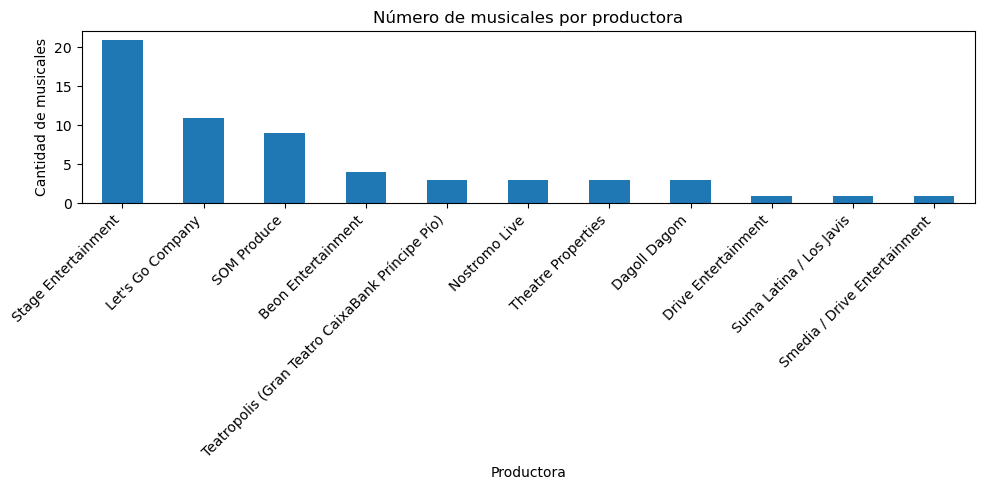

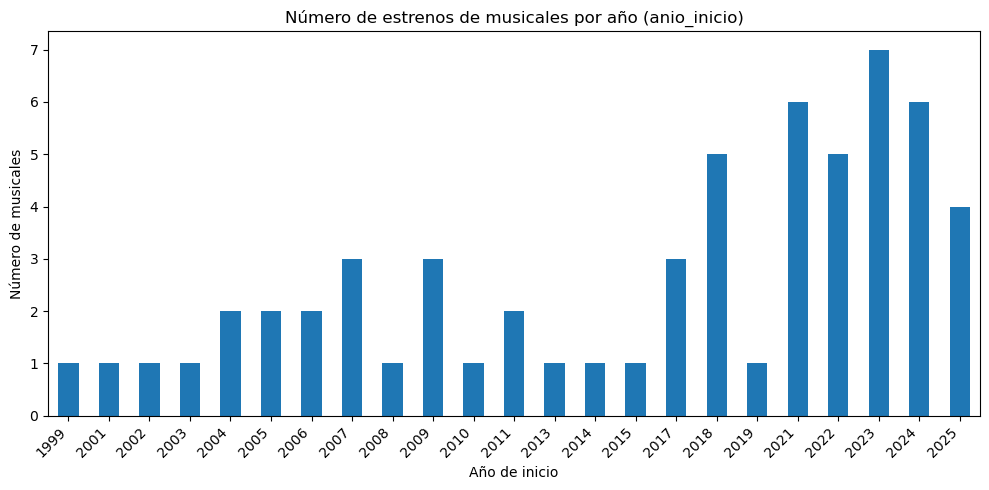

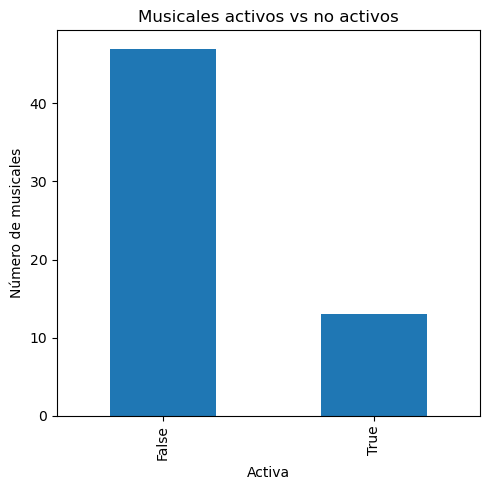

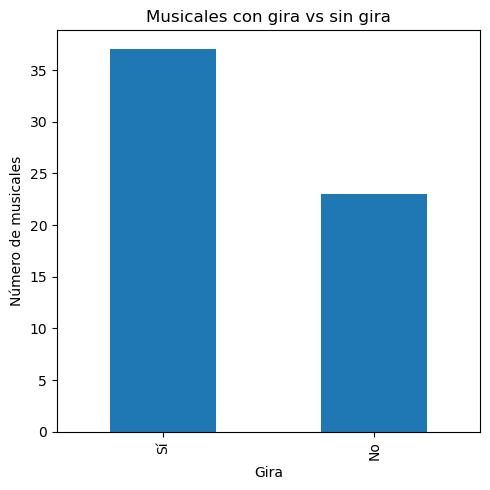

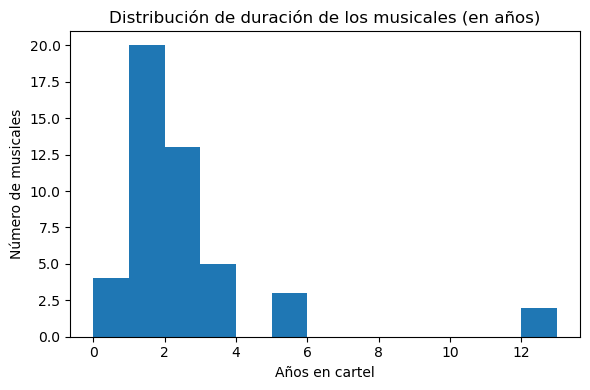

In [232]:
# 1. RE-CHEQUEO POST-LIMPIEZA
# =====================================================

print("=== NULOS POR COLUMNA ===")
display(df.isnull().sum())

print("\n=== FILAS DUPLICADAS POR CLAVE (obra, productora, anio_inicio) ===")
dup_clave = df.duplicated(subset=["obra", "productora", "anio_inicio"]).sum()
print(f"Número de filas duplicadas: {dup_clave}")

print("\n=== VALORES ÚNICOS POR COLUMNA ===")
display(df.nunique())

# =====================================================
# 2. NORMALIZACIÓN LIGERA DE CAMPOS DE TEXTO
# Strip general de espacios en columnas clave
for col in ["obra", "productora", "teatro", "ciudad_principal", "gira"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Normalizar 'gira' a 'Sí' / 'No'
if "gira" in df.columns:
    mapa_gira = {
        "Si": "Sí",
        "SI": "Sí",
        "sí": "Sí",
        "sI": "Sí",
        "No": "No",
        "NO": "No",
        "no": "No"
    }
    df["gira"] = df["gira"].replace(mapa_gira)

# =====================================================
# 3. GUARDAR CSV LIMPIO
# =====================================================

df.to_csv("musicales_limpio_final.csv", index=False, encoding="utf-8")
print("\nArchivo 'musicales_limpio_final.csv' guardado correctamente.")

# =====================================================
# 4. VISUALIZACIONES BÁSICAS
# =====================================================

# ---- 4.1 Número de musicales por productora ----
plt.figure(figsize=(10,5))
df["productora"].value_counts().plot(kind="bar")
plt.title("Número de musicales por productora")
plt.xlabel("Productora")
plt.ylabel("Cantidad de musicales")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---- 4.2 Estrenos de musicales por año de inicio ----
plt.figure(figsize=(10,5))
df.groupby("anio_inicio")["obra"].count().plot(kind="bar")
plt.title("Número de estrenos de musicales por año (anio_inicio)")
plt.xlabel("Año de inicio")
plt.ylabel("Número de musicales")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---- 4.3 Musicales activos vs no activos ----
plt.figure(figsize=(5,5))
df["activa"].value_counts().plot(kind="bar")
plt.title("Musicales activos vs no activos")
plt.xlabel("Activa")
plt.ylabel("Número de musicales")
plt.tight_layout()
plt.show()

# ---- 4.4 Musicales con gira vs sin gira ----
if "gira" in df.columns:
    plt.figure(figsize=(5,5))
    df["gira"].value_counts().plot(kind="bar")
    plt.title("Musicales con gira vs sin gira")
    plt.xlabel("Gira")
    plt.ylabel("Número de musicales")
    plt.tight_layout()
    plt.show()

#4.5 Distribución de duración (años en cartel) ----
# Solo para musicales que tienen anio_fin definido
if "anio_fin" in df.columns:
    df_duracion = df[df["anio_fin"].notna()].copy()
    # Convertir a numéricos por si acaso
    df_duracion["anio_inicio"] = pd.to_numeric(df_duracion["anio_inicio"], errors="coerce")
    df_duracion["anio_fin"] = pd.to_numeric(df_duracion["anio_fin"], errors="coerce")
    df_duracion["duracion_anios"] = df_duracion["anio_fin"] - df_duracion["anio_inicio"]

    plt.figure(figsize=(6,4))
    df_duracion["duracion_anios"].dropna().plot(kind="hist", bins=range(0, df_duracion["duracion_anios"].max()+2))
    plt.title("Distribución de duración de los musicales (en años)")
    plt.xlabel("Años en cartel")
    plt.ylabel("Número de musicales")
    plt.tight_layout()
    plt.show()

Persisten algunos nulos en `ciudad_principal` y `teatro` que se dejan explícitos en la exportación para no introducir suposiciones incorrectas.

In [233]:
df.to_csv("Eda_data_musicales.csv", index=False, encoding="utf-8")


## 7. Conclusiones del EDA

- El dataset consolidado recoge producciones de teatro musical en España con información coherente sobre obra, productora, periodo de exhibición, teatro principal y ciudad.
- La combinación de eliminación de duplicados y uso de claves lógicas ha permitido reducir ruido y mantener una fila por producción y año de inicio.
- La corrección manual de casos concretos (por ejemplo, cambios de teatro o ajustes de años de fin) se ha apoyado en fuentes oficiales del sector.
- La mayoría de valores nulos se han reducido a unos pocos casos en campos como `teatro` o `ciudad_principal`, que se mantienen explícitos para evitar introducir datos inventados.
- El dataset queda preparado para análisis posteriores: visualizaciones en Power BI o herramientas similares, así como posibles modelos que relacionen actividad del sector con otras variables externas.
